In [11]:
Packages <- c("nleqslv", "broom","cubature", "geosphere", "data.table",  "ggplot2", "bbmle", "dplyr","tidyr", "stringr", "tidyverse", "lubridate", "RColorBrewer")

invisible(suppressPackageStartupMessages(lapply(Packages, library, character.only = TRUE)))

setwd('/local/home/katrinac/oceanography')
"%!in%" <- function(x,table) match(x,table, nomatch = 0) == 0
source("~/parentage/kernel_fitting/1340_loci/functions/ll_kt_both_bbmle.R")
source("~/parentage/kernel_fitting/1340_loci/functions/GenGausKernInt_sum0.5.R") #integrate_kernel_sum1
source("~/parentage/kernel_fitting/1340_loci/functions/GenGausKernInt_sum1.R") #integrate_kernel_sum0.5
source("~/parentage/kernel_fitting/1340_loci/functions/cdf_solve.R") #median
source("~/parentage/kernel_fitting/1340_loci/functions/cdf_solve90.R") #dist 90% retained
source("~/parentage/kernel_fitting/1340_loci/functions/GenGausKernPDF.R")
#define my own cv function
cv <- function(x){
    sd(x)/mean(x)
}
#make a mean dispersal distance function that can be applied to a DT rather than for loop method I've used in the past

mean_disp_dist <- function(k, theta){
    
x <- as.numeric(cubintegrate(integrate_kernel_sum1, lower = 0, upper = Inf, k=k, theta=theta, , method = "pcubature")$integral)

return(x)

}

In [12]:
#read in the simulation kernel fits
SimKernels <- fread("~/oceanography/script_output/KernelFits/SimulationKernelFits.csv")
#setnames(SimKernels, c("TimeID", "TimeScale"), c("time_id", "time_scale")) #from now on, DTs will be named LikeThis, vectors (including colnames and row ids) will be like_this- until I get around to making that consistent in every script, rename here
#read in the Genetics kernel fits with the same reef metadata structure
GenKernels <- fread("~/oceanography/script_output/KernelFits/GeneticKernelFits.csv")

#read in the likelihood surfaces tables
#Geneticss
ProfileGen2012 <- fread(file="~/oceanography/script_output/KernelFits/LikelihoodProfileGenetic2012.csv", header = T)
#setnames(ProfileGen2012, "V1", "k_eval")
#melt into long format
#ProfileGen2012 <- melt(ProfileGen2012, id.vars = c("k_eval"), variable.name = "theta_eval", value.name = "log_like")[, theta_eval := as.numeric(as.character(theta_eval))]

ProfileGen2013 <- fread(file="~/oceanography/script_output/KernelFits/LikelihoodProfileGenetic2013.csv", header = T)
setnames(ProfileGen2013, "V1", "k_eval")
#melt into long format
ProfileGen2013 <- melt(ProfileGen2013, id.vars = c("k_eval"), variable.name = "theta_eval", value.name = "log_like")[, theta_eval := as.numeric(as.character(theta_eval))]

ProfileGen2014 <- fread(file="~/oceanography/script_output/KernelFits/LikelihoodProfileGenetic2014.csv", header = T)
setnames(ProfileGen2014, "V1", "k_eval")
#melt into long format
ProfileGen2014 <- melt(ProfileGen2014, id.vars = c("k_eval"), variable.name = "theta_eval", value.name = "log_like")[, theta_eval := as.numeric(as.character(theta_eval))]

ProfileGen2012_4 <- fread(file="~/oceanography/script_output/KernelFits/LikelihoodProfileGenetic2012-4.csv", header = T)
setnames(ProfileGen2012_4, "V1", "k_eval")
#melt into long format
ProfileGen2012_4 <- melt(ProfileGen2012_4, id.vars = c("k_eval"), variable.name = "theta_eval", value.name = "log_like")[, theta_eval := as.numeric(as.character(theta_eval))]

ProfileGenNEM <- fread(file="~/oceanography/script_output/KernelFits/LikelihoodProfileGeneticNEM.csv", header = T)
setnames(ProfileGenNEM, "V1", "k_eval")
#melt into long format
ProfileGenNEM <- melt(ProfileGenNEM, id.vars = c("k_eval"), variable.name = "theta_eval", value.name = "log_like")[, theta_eval := as.numeric(as.character(theta_eval))]

ProfileGenSWM <- fread(file="~/oceanography/script_output/KernelFits/LikelihoodProfileGeneticSWM.csv", header = T)
setnames(ProfileGenSWM, "V1", "k_eval")
#melt into long format
ProfileGenSWM <- melt(ProfileGenSWM, id.vars = c("k_eval"), variable.name = "theta_eval", value.name = "log_like")[, theta_eval := as.numeric(as.character(theta_eval))]

#ROMS simulations
ProfileSim2012 <- fread(file="~/oceanography/script_output/KernelFits/LikelihoodProfileBiophysical2012NarrowSearch.csv", header = T)
setnames(ProfileSim2012, "V1", "k_eval")
#melt into long format
ProfileSim2012 <- melt(ProfileSim2012, id.vars = c("k_eval"), variable.name = "theta_eval", value.name = "log_like")[, theta_eval := as.numeric(as.character(theta_eval))]#[, log_like := -log_like]

ProfileSim2013 <- fread(file="~/oceanography/script_output/KernelFits/LikelihoodProfileBiophysical2013.csv", header = T)
setnames(ProfileSim2013, "V1", "k_eval")
#melt into long format
ProfileSim2013 <- melt(ProfileSim2013, id.vars = c("k_eval"), variable.name = "theta_eval", value.name = "log_like")[, theta_eval := as.numeric(as.character(theta_eval))]

ProfileSim2014 <- fread(file="~/oceanography/script_output/KernelFits/LikelihoodProfileBiophysical2014.csv", header = T)
setnames(ProfileSim2014, "V1", "k_eval")
#melt into long format
ProfileSim2014 <- melt(ProfileSim2014, id.vars = c("k_eval"), variable.name = "theta_eval", value.name = "log_like")[, theta_eval := as.numeric(as.character(theta_eval))]

ProfileSim2012_4 <- fread(file="~/oceanography/script_output/KernelFits/LikelihoodProfileBiophysical2012-4.csv", header = T)
setnames(ProfileSim2012_4, "V1", "k_eval")
#melt into long format
ProfileSim2012_4 <- melt(ProfileSim2012_4, id.vars = c("k_eval"), variable.name = "theta_eval", value.name = "log_like")[, theta_eval := as.numeric(as.character(theta_eval))]

ProfileSimNEM <- fread(file="~/oceanography/script_output/KernelFits/LikelihoodProfileBiophysicalNEM.csv", header = T)
setnames(ProfileSimNEM, "V1", "k_eval")
#melt into long format
ProfileSimNEM <- melt(ProfileSimNEM, id.vars = c("k_eval"), variable.name = "theta_eval", value.name = "log_like")[, theta_eval := as.numeric(as.character(theta_eval))]

ProfileSimSWM <- fread(file="~/oceanography/script_output/KernelFits/LikelihoodProfileBiophysicalSWM.csv", header = T)
setnames(ProfileSimSWM, "V1", "k_eval")
#melt into long format
ProfileSimSWM <- melt(ProfileSimSWM, id.vars = c("k_eval"), variable.name = "theta_eval", value.name = "log_like")[, theta_eval := as.numeric(as.character(theta_eval))]

#ensure the likelihood surfaces found the same best fit as the bbmle optimization for both simulation and Geneticss
#done
#calculate the 95% likelihood surface cutoffs. Use the log_like from the bbmle function because that's more precise. in the grid search function used for the surfaces, k/theta are limited to 2 decimal places because it's less computation time, but in some cases that means the MLE is from an artificial local optimum that only exists because decimal places are truncated
#genetics
cutoff_Gen2012 <- -(GenKernels[time_id=="2012", log_like]) + qchisq(0.95, 2)/2 #use the 95% quantile of the chi-sq distribution with two df because it's bivariate
#pull out the values above the cutoff
ProfileGen2012_CI95 <- ProfileGen2012[log_like < cutoff_Gen2012][, `:=`(data_source="genetics", time_id="2012", cutoff=cutoff_Gen2012, best_k=GenKernels[time_id=="2012", k], best_theta=GenKernels[time_id=="2012", theta])]

cutoff_Gen2013 <- -(GenKernels[time_id=="2013", log_like]) + qchisq(0.95, 2)/2 #use the 95% quantile of the chi-sq distribution with two df because it's bivariate
#pull out the values above the cutoff
ProfileGen2013_CI95 <- ProfileGen2013[log_like < cutoff_Gen2013][, `:=`(data_source="genetics", time_id="2013", cutoff=cutoff_Gen2013, best_k=GenKernels[time_id=="2013", k], best_theta=GenKernels[time_id=="2013", theta])]

cutoff_Gen2014 <- -(GenKernels[time_id=="2014", log_like]) + qchisq(0.95, 2)/2 #use the 95% quantile of the chi-sq distribution with two df because it's bivariate
#pull out the values above the cutoff
ProfileGen2014_CI95 <- ProfileGen2014[log_like < cutoff_Gen2014][, `:=`(data_source="genetics", time_id="2014", cutoff=cutoff_Gen2014, best_k=GenKernels[time_id=="2014", k], best_theta=GenKernels[time_id=="2014", theta])]

cutoff_Gen2012_4 <- -(GenKernels[time_id=="2012-4", log_like]) + qchisq(0.95, 2)/2 #use the 95% quantile of the chi-sq distribution with two df because it's bivariate
#pull out the values above the cutoff
ProfileGen2012_4_CI95 <- ProfileGen2012_4[log_like < cutoff_Gen2012_4][, `:=`(data_source="genetics", time_id="2012-4", cutoff=cutoff_Gen2012_4,  best_k=GenKernels[time_id=="2012-4", k], best_theta=GenKernels[time_id=="2012-4", theta])]

cutoff_GenNEM <- -(GenKernels[time_id=="NEM", log_like]) + qchisq(0.95, 2)/2 #use the 95% quantile of the chi-sq distribution with two df because it's bivariate
#pull out the values above the cutoff
ProfileGenNEM_CI95 <- ProfileGenNEM[log_like < cutoff_GenNEM][, `:=`(data_source="genetics", time_id="NEM", cutoff=cutoff_GenNEM, best_k=GenKernels[time_id=="NEM", k], best_theta=GenKernels[time_id=="NEM", theta])]

cutoff_GenSWM <- -(GenKernels[time_id=="SWM", log_like]) + qchisq(0.95, 2)/2 #use the 95% quantile of the chi-sq distribution with two df because it's bivariate
#pull out the values above the cutoff
ProfileGenSWM_CI95 <- ProfileGenSWM[log_like < cutoff_GenSWM][, `:=`(data_source="genetics", time_id="SWM", cutoff=cutoff_GenSWM, best_k=GenKernels[time_id=="SWM", k], best_theta=GenKernels[time_id=="SWM", theta])]

#biophysical simulation
cutoff_Sim2012 <- -(SimKernels[time_id=="2012", log_like]) + qchisq(0.95, 2)/2 #use the 95% quantile of the chi-sq distribution with two df because it's bivariate
#pull out the values above the cutoff
#ProfileSim2012_CI95 <- ProfileSim2012[log_like < cutoff_Sim2012][, `:=`(data_source="simulation", time_id="2012", cutoff=cutoff_Sim2012, best_k=SimKernels[time_id=="2012", k], best_theta=SimKernels[time_id=="2012", theta])]
ProfileSim2012_CI95 <- ProfileSim2012[, `:=`(data_source="simulation", time_id="2012", cutoff=cutoff_Sim2012, best_k=SimKernels[time_id=="2012", k], best_theta=SimKernels[time_id=="2012", theta])]

cutoff_Sim2013 <- -(SimKernels[time_id=="2013", log_like]) + qchisq(0.95, 2)/2 #use the 95% quantile of the chi-sq distribution with two df because it's bivariate
#pull out the values above the cutoff
#ProfileSim2013_CI95 <- ProfileSim2013[log_like < cutoff_Sim2013][, `:=`(data_source="simulation", time_id="2013", cutoff=cutoff_Sim2013, best_k=SimKernels[time_id=="2013", k], best_theta=SimKernels[time_id=="2013", theta])]
ProfileSim2013_CI95 <- ProfileSim2013[, `:=`(data_source="simulation", time_id="2013", cutoff=cutoff_Sim2013, best_k=SimKernels[time_id=="2013", k], best_theta=SimKernels[time_id=="2013", theta])]

cutoff_Sim2014 <- -(SimKernels[time_id=="2014", log_like]) + qchisq(0.95, 2)/2 #use the 95% quantile of the chi-sq distribution with two df because it's bivariate
#pull out the values above the cutoff
#ProfileSim2014_CI95 <- ProfileSim2014[log_like < cutoff_Sim2014][, `:=`(data_source="simulation", time_id="2014", cutoff=cutoff_Sim2014,  best_k=SimKernels[time_id=="2014", k], best_theta=SimKernels[time_id=="2014", theta])]
ProfileSim2014_CI95 <- ProfileSim2014[, `:=`(data_source="simulation", time_id="2014", cutoff=cutoff_Sim2014,  best_k=SimKernels[time_id=="2014", k], best_theta=SimKernels[time_id=="2014", theta])]

cutoff_Sim2012_4 <- -(SimKernels[time_id=="2012-4", log_like]) + qchisq(0.95, 2)/2 #use the 95% quantile of the chi-sq distribution with two df because it's bivariate
#pull out the values above the cutoff
#ProfileSim2012_4_CI95 <- ProfileSim2012_4[log_like < cutoff_Sim2012_4][, `:=`(data_source="simulation", time_id="2012-4", cutoff=cutoff_Sim2012_4,  best_k=SimKernels[time_id=="2012-4", k], best_theta=SimKernels[time_id=="2012-4", theta])]
ProfileSim2012_4_CI95 <- ProfileSim2012_4[, `:=`(data_source="simulation", time_id="2012-4", cutoff=cutoff_Sim2012_4,  best_k=SimKernels[time_id=="2012-4", k], best_theta=SimKernels[time_id=="2012-4", theta])]

cutoff_SimNEM <- -(SimKernels[time_id=="NEM", log_like]) + qchisq(0.95, 2)/2 #use the 95% quantile of the chi-sq distribution with two df because it's bivariate
#pull out the values above the cutoff
#ProfileSimNEM_CI95 <- ProfileSimNEM[log_like < cutoff_SimNEM][, `:=`(data_source="simulation", time_id="NEM", cutoff=cutoff_SimNEM,  best_k=SimKernels[time_id=="NEM", k], best_theta=SimKernels[time_id=="NEM", theta])]
ProfileSimNEM_CI95 <- ProfileSimNEM[, `:=`(data_source="simulation", time_id="NEM", cutoff=cutoff_SimNEM,  best_k=SimKernels[time_id=="NEM", k], best_theta=SimKernels[time_id=="NEM", theta])]

cutoff_SimSWM <- -(SimKernels[time_id=="SWM", log_like]) + qchisq(0.95, 2)/2 #use the 95% quantile of the chi-sq distribution with two df because it's bivariate
#pull out the values above the cutoff
#ProfileSimSWM_CI95 <- ProfileSimSWM[log_like < cutoff_SimSWM][, `:=`(data_source="simulation", time_id="SWM", cutoff=cutoff_SimSWM,  best_k=SimKernels[time_id=="SWM", k], best_theta=SimKernels[time_id=="SWM", theta])]
ProfileSimSWM_CI95 <- ProfileSimSWM[, `:=`(data_source="simulation", time_id="SWM", cutoff=cutoff_SimSWM,  best_k=SimKernels[time_id=="SWM", k], best_theta=SimKernels[time_id=="SWM", theta])]



ERROR: Error in .checkTypos(e, names(x)): Object 'log_like' not found amongst V1, 0.1, 0.11, 0.12, 0.13 and 487 more


In [23]:
ProfileSim2012 <- fread(file="~/oceanography/script_output/KernelFits/LikelihoodProfileBiophysical2012.csv", header = T)


In [24]:
head(ProfileSim2012)

k_eval,theta_eval,log_like
-10.000000,0.1,358155.1
-9.989995,0.1,358144.4
-9.979990,0.1,358133.7
-9.969985,0.1,358122.9
-9.959980,0.1,358112.2
-9.949975,0.1,358101.4


In [15]:
cutoff_Sim2012 <- -(SimKernels[time_id=="2012", log_like]) + qchisq(0.95, 2)/2 #use the 95% quantile of the chi-sq distribution with two df because it's bivariate
#pull out the values above the cutoff
ProfileSim2012_CI95 <- ProfileSim2012[log_like < cutoff_Sim2012][, `:=`(data_source="simulation", time_id="2012", cutoff=cutoff_Sim2012, best_k=SimKernels[time_id=="2012", k], best_theta=SimKernels[time_id=="2012", theta])]


ERROR: Error in .checkTypos(e, names(x)): Object 'log_like' not found amongst V1, 2.99, 2.991, 2.992, 2.993 and 2007 more


[1] 148586.1

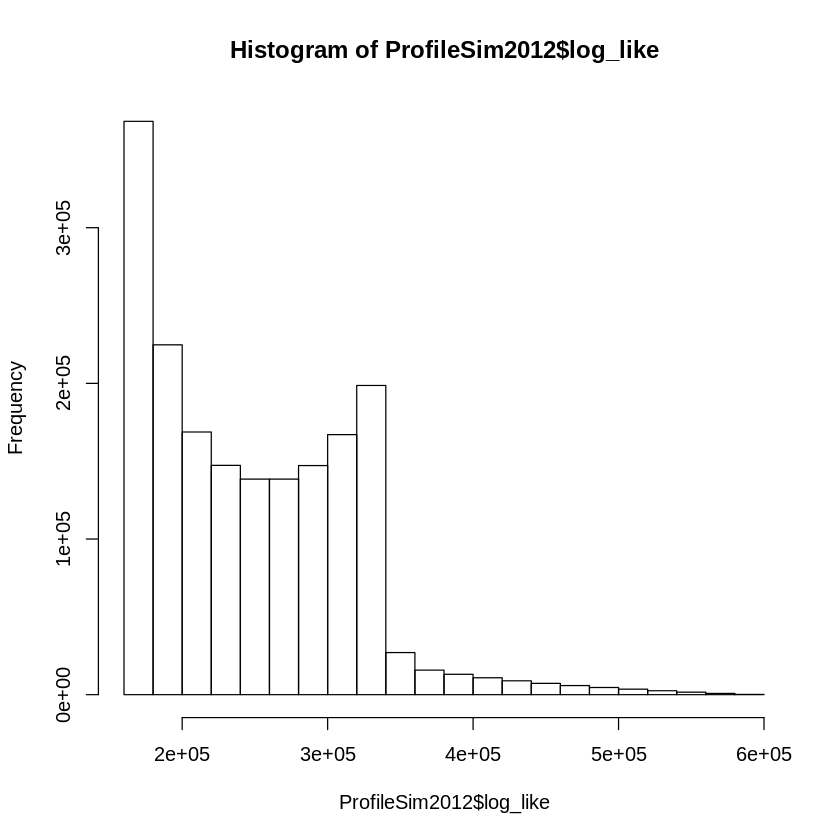

In [32]:
#check that cutoffs make sense
cutoff_Sim2012
#hist(ProfileSim2012_CI95$log_like)
hist(ProfileSim2012$log_like)

In [33]:
head(ProfileSimNEM)


k_eval,theta_eval,log_like
-10.00,0.1,3075751
-9.99,0.1,3075648
-9.98,0.1,3075544
-9.97,0.1,3075440
-9.96,0.1,3075336
-9.95,0.1,3075232


In [15]:
SimKernels

time_scale,time_id,k,theta,mdd,med,dist90,log_like,data_source
annual,2012,-2.16,4.99,4.21,4.01,7.88,-148583.15,simulation
annual,2013,-0.46,0.63,4.21,2.32,10.38,-549040.28,simulation
annual,2014,0.28,0.53,3.65,1.78,9.16,-527734.31,simulation
interannual,2012-4,-0.10,0.58,3.90,2.03,9.72,-1682004.75,simulation
season,NEM,-0.23,0.61,3.71,2.00,9.19,-1566546.34,simulation
season,SWM,0.60,0.42,7.89,3.17,20.02,-90949.14,simulation


In [20]:
head(ProfileGen2012_4_CI95)

k_eval,theta_eval,log_like,data_source,time_id,cutoff,best_k,best_theta
2.24,0.26,221.6008,genetics,2012-4,221.61,-0.23,0.44
2.25,0.26,221.5890,genetics,2012-4,221.61,-0.23,0.44
2.26,0.26,221.5793,genetics,2012-4,221.61,-0.23,0.44
2.27,0.26,221.5719,genetics,2012-4,221.61,-0.23,0.44
2.28,0.26,221.5668,genetics,2012-4,221.61,-0.23,0.44
2.29,0.26,221.5640,genetics,2012-4,221.61,-0.23,0.44


In [35]:
##combine into one table for plotting, maybe move to later after getting upper and lower profiles
GenPlusSimKernels95CI <- rbindlist(list(ProfileGen2012_CI95, ProfileGen2013_CI95, ProfileGen2013_CI95, ProfileGen2014_CI95, ProfileGen2012_4_CI95, ProfileGenNEM_CI95, ProfileGenSWM_CI95,
             ProfileSim2012_CI95, ProfileSim2013_CI95, ProfileSim2014_CI95, ProfileSim2012_4_CI95, ProfileSimNEM_CI95, ProfileSimSWM_CI95))
##fwrite(GenPlusSimKernels95CI, "~/oceanography/script_output/KernelFits/GenPlusSimKernels95CI.csv")

In [36]:
SimKernels
GenPlusSimKernels95CI[, .N, by=.(time_id, data_source)]

time_scale,time_id,k,theta,mdd,med,dist90,log_like,data_source
annual,2012,-2.16,4.99,4.21,4.01,7.88,-148583.15,simulation
annual,2013,-0.46,0.63,4.21,2.32,10.38,-549040.28,simulation
annual,2014,0.28,0.53,3.65,1.78,9.16,-527734.31,simulation
interannual,2012-4,-0.10,0.58,3.90,2.03,9.72,-1682004.75,simulation
season,NEM,-0.23,0.61,3.71,2.00,9.19,-1566546.34,simulation
season,SWM,0.60,0.42,7.89,3.17,20.02,-90949.14,simulation


time_id,data_source,N
2012,genetics,32718
2013,genetics,2054
2014,genetics,7292
2012-4,genetics,6585
NEM,genetics,16008
SWM,genetics,2846
2012,simulation,1801099
2013,simulation,982491
2014,simulation,982491
2012-4,simulation,982491


In [39]:
GenPlusSimKernels95CI <- GenPlusSimKernels95CI[, lower_profile :=ifelse(k_eval <= best_k & theta_eval <= best_theta, "yes", "no"), by=.(time_id, data_source)][ #mark k/theta combos that are in the lower profile with "yes"
        , upper_profile :=ifelse(k_eval >= best_k & theta_eval >= best_theta, "yes", "no"), by=.(time_id, data_source)][ #mark the upper profile in the same way
        , max_log_like := max(log_like), by=.(time_id, data_source, upper_profile, lower_profile)]


In [43]:
tail(GenPlusSimKernels95CI)

k_eval,theta_eval,log_like,data_source,time_id,cutoff,best_k,best_theta,lower_profile,upper_profile,max_log_like
9.95,5,3008272,simulation,SWM,90952.14,0.6,0.42,no,yes,3008272
9.96,5,3008272,simulation,SWM,90952.14,0.6,0.42,no,yes,3008272
9.97,5,3008272,simulation,SWM,90952.14,0.6,0.42,no,yes,3008272
9.98,5,3008272,simulation,SWM,90952.14,0.6,0.42,no,yes,3008272
9.99,5,3008272,simulation,SWM,90952.14,0.6,0.42,no,yes,3008272
10.00,5,3008272,simulation,SWM,90952.14,0.6,0.42,no,yes,3008272


In [58]:
#get the CIs and compare make sure they make sense
GenPlusSimKernels95CISummaryLower <- GenPlusSimKernels95CI[
    lower_profile=="yes"][log_like==max_log_like, .(lower_k=k_eval, lower_theta=theta_eval) ,by=c("time_id", "data_source")]#[
GenPlusSimKernels95CISummaryUpper <- GenPlusSimKernels95CI[
    upper_profile=="yes"][log_like==max_log_like, .(upper_k=k_eval, upper_theta=theta_eval) ,by=c("time_id", "data_source")]#[


In [66]:
str(GenPlusSimKernels95CISummaryLower)
nrow(GenPlusSimKernels95CISummaryUpper)

Classes ‘data.table’ and 'data.frame':	15 obs. of  4 variables:
 $ time_id    : chr  "2012" "2012" "2014" "2014" ...
 $ data_source: chr  "genetics" "genetics" "genetics" "genetics" ...
 $ lower_k    : num  -3.46 -3.27 1.24 1.97 -0.24 -0.23 0.56 0.76 -10 -10 ...
 $ lower_theta: num  1.71 3.53 0.24 0.26 0.4 0.44 0.31 0.37 0.63 0.53 ...
 - attr(*, ".internal.selfref")=<externalptr> 


[1] 1545635

In [64]:
GenPlusSimKernels95CISummaryLower[GenPlusSimKernels95CISummaryUpper, on=.(time_id, data_source), allow.cartesian=T]

time_id,data_source,lower_k,lower_theta,upper_k,upper_theta
2012,genetics,-3.46,1.71,-3.27,3.53
2012,genetics,-3.27,3.53,-3.27,3.53
2012,genetics,-3.46,1.71,-3.13,3.66
2012,genetics,-3.27,3.53,-3.13,3.66
2014,genetics,1.24,0.24,1.97,0.26
2014,genetics,1.97,0.26,1.97,0.26
2014,genetics,1.24,0.24,2.01,0.29
2014,genetics,1.97,0.26,2.01,0.29
2012-4,genetics,-0.24,0.40,-0.23,0.44
2012-4,genetics,-0.23,0.44,-0.23,0.44


In [46]:
GenKernels
SimKernels

time_scale,time_id,k,theta,mdd,med,dist90,log_like,data_source
annual,2012,-3.27,3.53,13.02,12.02,25.08,-17.26499,genetics
annual,2013,-3.38,8.00,14.20,13.89,25.94,-111.36299,genetics
annual,2014,1.97,0.26,76.17,17.50,182.75,-78.48620,genetics
interannual,2012-4,-0.23,0.44,13.69,5.77,34.74,-218.61429,genetics
season,NEM,0.76,0.37,12.87,4.64,32.61,-27.26112,genetics
season,SWM,-3.46,8.00,15.35,15.02,28.05,-70.92640,genetics


time_scale,time_id,k,theta,mdd,med,dist90,log_like,data_source
annual,2012,-2.16,4.99,4.21,4.01,7.88,-148583.15,simulation
annual,2013,-0.46,0.63,4.21,2.32,10.38,-549040.28,simulation
annual,2014,0.28,0.53,3.65,1.78,9.16,-527734.31,simulation
interannual,2012-4,-0.10,0.58,3.90,2.03,9.72,-1682004.75,simulation
season,NEM,-0.23,0.61,3.71,2.00,9.19,-1566546.34,simulation
season,SWM,0.60,0.42,7.89,3.17,20.02,-90949.14,simulation


In [42]:
GenPlusSimKernels95CI[time_id=="2012" & lower_profile=="yes" & data_source=="simulation"][log_like==max(log_like)][, .(lower_k=k_eval, lower_theta=theta_eval, log_like, data_source, time_id, cutoff, best_k, best_theta)]
GenPlusSimKernels95CI[time_id=="2012" & upper_profile=="yes" & data_source=="simulation"][log_like==max(log_like)][, .(upper_k=k_eval, upper_theta=theta_eval, log_like, data_source, time_id, cutoff, best_k, best_theta)]


Warning message in max(log_like):
“no non-missing arguments to max; returning -Inf”

lower_k,lower_theta,log_like,data_source,time_id,cutoff,best_k,best_theta


Warning message in max(log_like):
“no non-missing arguments to max; returning -Inf”

upper_k,upper_theta,log_like,data_source,time_id,cutoff,best_k,best_theta


In [69]:
GenPlusSimKernels95CI[time_id=="2012" & upper_profile=="yes" & data_source=="genetics"][log_like==max(log_like)][, .(upper_k=k_eval, upper_theta=theta_eval, log_like, data_source, time_id, cutoff, best_k, best_theta)]


upper_k,upper_theta,log_like,data_source,time_id,cutoff,best_k,best_theta
-3.13,3.66,20.2601,genetics,2012,20.26073,-3.27,3.53


In [ ]:
GenKernels[time_id=="2012", log_like])

lower_profile_all <- ProfileGen2012_4_CI95 %>%
    filter(k_eval <= best_k_all & theta_eval <= best_theta_all)


#pull out the values above the cutoff
upper_profile_all <- profile_all_df95 %>%
    filter(k_eval >= best_k_all & theta_eval >= best_theta_all)

upper_all <- upper_profile_all %>%
    filter(log_like== max(log_like))
lower_all <- lower_profile_all %>%
    filter(log_like== max(log_like))

upper_k_all <- as.numeric(upper_all %>%
                          select(k_eval))
upper_theta_all <- as.numeric(upper_all %>%
                          select(theta_eval))
lower_k_all <- as.numeric(lower_all %>%
                          select(k_eval))
lower_theta_all <- as.numeric(lower_all %>%
                          select(theta_eval))
upper_k_all

In [97]:
head(GenPlusSimKernels95CI)

k_eval,theta_eval,log_like,data_source,time_id,cutoff
0.42,0.31,20.25926,genetics,2012,20.26073
0.43,0.31,20.25766,genetics,2012,20.26073
0.44,0.31,20.25617,genetics,2012,20.26073
0.45,0.31,20.25477,genetics,2012,20.26073
0.46,0.31,20.25348,genetics,2012,20.26073
0.47,0.31,20.25229,genetics,2012,20.26073


In [78]:
#plot likelihood surface
cbbPalette <- c("#D55E00", "#0072B2", "#F0E442", "#009E73", "#56B4E9", "#E69F00", "#CC79A7") 


stat_contour <- ggplot(data=ProfileGen2012, aes(x=k_eval, y=theta_eval)) +
    stat_contour(data=GenPlusSimKernels95CI[time_id=="2012-4" & data_source=="genetics"], aes(z = log_like), breaks = GenPlusSimKernels95CI[time_id=="2012-4" & data_source=="genetics", cutoff][1], size=1.5, colour="#D55E00") +
    #stat_contour(data=profile_13_df %>% filter(theta_eval <= 5 & k_eval <=10), aes(z = log_like), breaks = cutoff_Gen2013, size=1, colour="#0072B2", alpha= 0.6) +
    #stat_contour(data=profile_14_df %>% filter(theta_eval <= 5 & k_eval <=10), aes(z = log_like), breaks = cutoff_Gen2014, size=1, colour="#F0E442", alpha= 0.6) +
    #stat_contour(data=profile_15_df %>% filter(theta_eval <= 5 & k_eval <=10), aes(z = log_like), breaks = cutoff_Gen2012_4, size=1, colour="#009E73", alpha= 0.6) +
    #stat_contour(data=profile_16_df %>% filter(theta_eval <= 5 & k_eval <=10), aes(z = log_like), breaks = cutoff_Gen16, size=1, colour="#56B4E9", alpha= 0.6) +
    #stat_contour(data=profile_17_df %>% filter(theta_eval <= 5 & k_eval <=10), aes(z = log_like), breaks = cutoff_Gen17, size=1, colour="#E69F00", alpha= 0.6) +
    #stat_contour(data=profile_18_df %>% filter(theta_eval <= 5 & k_eval <=10), aes(z = log_like), breaks = cutoff_Gen18, size=1, colour="#CC79A7", alpha= 0.6) +
    scale_x_continuous(breaks = seq(-10, 10, by = 1), expand = c(0, 0)) + 
    scale_y_continuous(breaks = seq(0.1, 5.3, by = 1), expand = c(0, 0)) +
    theme(legend.title=element_blank(),
    axis.text.x = element_text(size=12, color="black", family="Helvetica"),#15 for publication, 20 for presentation #element_text(size=15, color="black", family="Helvetica"),
    axis.text.y =  element_text(size=12, color="black", family="Helvetica"),
    axis.title.y =  element_text(size=14, color="black", family="Helvetica"), 
    axis.title.x =  element_text(size=14, color="black", family="Helvetica")) +
    xlab("k") + ylab(expression(theta)) +
    theme_bw()




#ggplot2::ggsave(filename="All95CISurfacesCombined_contour.png",  plot=stat_contour, path="~/parentage/kernel_fitting/1340_loci/final_results/likelihood_profiles_grid_search/")
#stat_contour


In [51]:
#calculate various summary stats that we will plot for 100 kernels in the CI of each time frame
GenPlusSimKernels95CISamp <- GenPlusSimKernels95CI[, .SD[sample(.N, 100, prob=max(log_like)/log_like)], by = c("time_id", "data_source")][ #weight the fits by distance from the best log like
    , `:=`(mdd=round(mean_disp_dist(k = k_eval, theta=theta_eval), 2),
                            med=round(nleqslv(x = 7, fn = cdf_solve, k=k_eval, theta=theta_eval)$x, 2),
                            dist90=round(nleqslv(x = 7, fn = cdf_solve90, k=k_eval, theta=theta_eval)$x, 2)),
                      by=c("k_eval", "theta_eval")]

In [53]:
#write out table with summary stats that are plotted to keep plots consistent
#fwrite(GenPlusSimKernels95CISamp, "~/oceanography/script_output/KernelFits/GenPlusSimKernels95CISummaryStatsSamp.csv")

In [13]:
GenPlusSimKernelsSummaryMLE <- rbind(SimKernels, GenKernels)#combine MLE from the bbmle optimization into one table, get CIs and write out again

#GenPlusSimKernelsSummaryMLE[, `:=`(lower_k=min(GenPlusSimKernels95CI[time_id==GenPlusSimKernelsSummaryMLE$time_id]))] #get the min/max of k/theta from the likelihood surface

In [99]:
CIs <- GenPlusSimKernels95CI[, .(lower_k=min(k_eval), upper_k=max(k_eval), lower_theta=min(theta_eval), upper_theta=max(theta_eval)), by=c("time_id", "data_source")]
GenPlusSimKernelsSummaryMLEWithCI <- CIs[GenPlusSimKernelsSummaryMLE, on=c("time_id", "data_source")]

In [102]:
GenPlusSimKernelsSummaryMLEWithCI[theta> upper_theta | theta < lower_theta]
GenPlusSimKernelsSummaryMLEWithCI[k > upper_k | k < lower_k]

time_id,data_source,lower_k,upper_k,lower_theta,upper_theta,time_scale,k,theta,mdd,med,dist90,log_like
2012,simulation,-2.16,-2.16,4.86,4.97,annual,-2.16,4.99,4.21,4.01,7.88,-148583.1528
2013,genetics,-3.33,-3.02,2.64,5.00,annual,-3.38,8.00,14.20,13.89,25.94,-111.3630
SWM,genetics,-3.47,-3.04,1.90,5.00,season,-3.46,8.00,15.35,15.02,28.05,-70.9264


time_id,data_source,lower_k,upper_k,lower_theta,upper_theta,time_scale,k,theta,mdd,med,dist90,log_like
2013,simulation,-0.46,-0.46,0.63,0.63,annual,-0.46,0.63,4.21,2.32,10.38,-549040.284
2014,simulation,0.26,0.27,0.53,0.53,annual,0.28,0.53,3.65,1.78,9.16,-527734.314
2012-4,simulation,-0.13,-0.13,0.58,0.58,interannual,-0.10,0.58,3.90,2.03,9.72,-1682004.749
NEM,simulation,-0.24,-0.24,0.61,0.61,season,-0.23,0.61,3.71,2.00,9.19,-1566546.337
2013,genetics,-3.33,-3.02,2.64,5.00,annual,-3.38,8.00,14.20,13.89,25.94,-111.363


In [105]:
test <- GenPlusSimKernels95CI[GenPlusSimKernelsSummaryMLE[, .(time_id, data_source, k, theta)], on=c("time_id", "data_source")]


k_eval,theta_eval,log_like,data_source,time_id,cutoff,k,theta
-2.16,4.86,148587.2,simulation,2012,148587.5,-2.16,4.99
-2.16,4.87,148586.3,simulation,2012,148587.5,-2.16,4.99
-2.16,4.88,148585.6,simulation,2012,148587.5,-2.16,4.99
-2.16,4.89,148585.1,simulation,2012,148587.5,-2.16,4.99
-2.16,4.90,148584.9,simulation,2012,148587.5,-2.16,4.99
-2.16,4.91,148584.7,simulation,2012,148587.5,-2.16,4.99


In [112]:
test[theta_eval >= theta & k_eval >= k, .(k_eval, theta_eval, log_like, cutoff), by=c("time_id", "data_source")][
    log_like==max(log_like), .(k_eval, theta_eval, log_like, cutoff), by=c("time_id", "data_source")]

time_id,data_source,k_eval,theta_eval,log_like,cutoff
2013,simulation,-0.46,0.63,549042.3,549045.3


In [ ]:
nrow(GenPlusSimKernels95CI)

In [ ]:
#add the CI for k/theta in each case to the kernel summary tables and write out again as summary table
SimKernels <- fwrite("~/oceanography/script_output/KernelFits/SimulationKernelFitsSummaryStats.csv")
#setnames(SimKernels, c("TimeID", "TimeScale"), c("time_id", "time_scale")) #from now on, DTs will be named LikeThis, vectors (including colnames and row ids) will be like_this- until I get around to making that consistent in every script, rename here
#read in the Genetics kernel fits with the same reef metadata structure
GenKernels <- fwrite("~/oceanography/script_output/KernelFits/GeneticKernelFits.csv")[, data_source := "genetics"]


In [43]:
#plot
#make a df with the pdf values at each distance to plot for each kernel fit
#get all the case k and theta averages to plot
FitsToPlot <- SimPlusGenFits %>% 
    filter(variable %in% c("k", "theta") ) %>%
    filter(Stat=="Mean" | Stat=="MLE") #%>%
   #mutate(Adj=ifelse(is.na(Adj), "no", Adj)) #change the NAs to no for the genetic

SimCasesToPlot <- FitsToPlot %>% 
     distinct(Year, DataType)

#distances to plot
distances <- data.frame(dist=seq(0, 60, 0.1))

SimCasesToPlot$distance <- NA
SimCasesToPlot$dispersal <- NA


SimToPlot <- SimCasesToPlot[FALSE,]

#make a long form df for each combo to plot

for(i in 1:nrow(SimCasesToPlot)){
    
    case_eval <- SimCasesToPlot[i,] #select row by position, each row represents the average fit for a given year and case combination
    
    k_eval <- as.numeric(FitsToPlot %>% #pull out the avg value of k that matches the year/case
        ungroup() %>%
        filter(Year==case_eval$Year & DataType==case_eval$DataType & variable=="k") %>%
        select(value))
    
    theta_eval <- as.numeric(FitsToPlot %>% #pull out the avg value of theta that matches the year/case
        ungroup() %>%
        filter(Year==case_eval$Year & DataType==case_eval$DataType & variable=="theta") %>%
        select(value))
    
    case_eval_build <- case_eval[FALSE,] #this will become the df with pdf at each distance for a given year/case combo

    for(j in 1:nrow(distances)){ #go through each distance and compute the pdf value. append the original df so that there's a row for each year/case/distance combination
        
        case_eval_beta <- case_eval
        
        dist_eval <- distances[j,]
        case_eval_beta$distance <- dist_eval
        case_eval_beta$dispersal <- predicted_disp(k=k_eval, theta=theta_eval, d=dist_eval)
        
        case_eval_build <- bind_rows(case_eval_build, case_eval_beta)
    
    }
    
        SimToPlot <- bind_rows(SimToPlot, case_eval_build) #add to the larger df that will eventually have all year/case/dist/pdf combos

}


     k_eval           theta_eval       log_like        data_source       
 Min.   :-10.0000   Min.   :0.100   Min.   :    -222   Length:11465165   
 1st Qu.: -4.7000   1st Qu.:1.250   1st Qu.:     172   Class :character  
 Median : -0.3820   Median :2.510   Median :  144259   Mode  :character  
 Mean   : -0.1112   Mean   :2.513   Mean   : 2505430                     
 3rd Qu.:  4.7000   3rd Qu.:3.750   3rd Qu.: 3008272                     
 Max.   : 10.0000   Max.   :5.000   Max.   :19458732                     
   time_id         
 Length:11465165   
 Class :character  
 Mode  :character  
                   
                   
                   

In [26]:
#BestFitGen2012_4 <- ProfileGen2012_4[neg_ll==max(neg_ll, na.rm = T)]


##find 95% CI, using instructions from Ben Bolker's Ecological Models in R and https://public.wsu.edu/~jesse.brunner/classes/bio572/Lab6_Likelihood.html
#best_ll_2012_4 <- as.numeric(BestFitGen2012_4$neg_ll)
#best_k_2012_4 <- as.numeric(BestFitGen2012_4$k_eval)
#best_theta_2012_4 <- as.numeric(BestFitGen2012_4$theta_eval)
cutoff_2012_4 <- GenKernels[time_id == "2012-4", log_like] - qchisq(0.95, 2)/2 #use the 95% quantile of the chi-sq distribution with two df because it's bivariate- minus rather than plus because we are using the inverse of the log likelihood to work with MLE functions

#pull out the values below the cutoff
ProfileGen2012_4_CI95 <- ProfileGen2012_4[log_like > cutoff_2012_4]

UpperProfileGen2012_4_CI95 <- ProfileGen2012_4_CI95[k_eval >= GenKernels[time_id == "2012-4", k] & theta_eval >= GenKernels[time_id == "2012-4", theta]]
LowerProfileGen2012_4_CI95 <- ProfileGen2012_4_CI95[k_eval <= GenKernels[time_id == "2012-4", k] & theta_eval <= GenKernels[time_id == "2012-4", theta]]

#extract the 95% CI for k and theta
lower_95CI_k_Gen2012_4 <- LowerProfileGen2012_4_CI95[log_like == max(LowerProfileGen2012_4_CI95$log_like, k)

time_id,N
2014,780
SWM,333
2013,196
NEM,9
2012-4,5
2012,7


In [9]:
#what if we throw out the boundary fits
SimKernels_test <- SimKernels[k!=10 &k!=-10 & theta!=0.15 &theta!= 8]


In [10]:
#make a summary table with means
SimMean <- SimKernels[, lapply(.SD, mean), by="time_id", #apply the mean function to get means of each column by time_id
             .SDcols = -c("iteration", "time_scale")] #but don't do that for iteration column
StatCol <- "Stat" #make the column to hold the Stat type
SimMean[,(StatCol):="mean"]      

SimMin <- SimKernels[, lapply(.SD, min), by="time_id", #apply the mean function to get means of each column by time_id
             .SDcols = -c("iteration", "time_scale")]
SimMin[,(StatCol):="min"]   

SimMax <- SimKernels[, lapply(.SD, max), by="time_id", #apply the mean function to get means of each column by time_id
             .SDcols = -c("iteration", "time_scale")]
SimMax[,(StatCol):="max"]  

SimCVWithin <- SimKernels[, lapply(.SD, cv), by="time_id", #apply the mean function to get means of each column by time_id
             .SDcols = -c("iteration", "time_scale", "k")] #because k is negative sometimes we can't use CV
SimCVWithin[,(StatCol):="cv_within"]

#bind together all Stats into one data.table
Stats <- list(SimMean, SimMin, SimMax, SimCVWithin)
SimSummary <- rbindlist(Stats, use.names=TRUE, fill=TRUE)

#make new column to ID this as a table with summary of SIMULATED data

data_typeCol <- "data_type" #make the column to hold data type
SimSummary[,(data_typeCol):="Sim"]
#fwrite(SimSummary, file="~/oceanography/script_output/KernelFits/SimulationKernelFitsSummary.csv")

In [11]:
head(SimSummary)

time_id,k,theta,mdd,med,dist90,Stat,data_type
2012,-1.1891536,0.7535468,30.539566,8.06433,62.85350,mean,Sim
2013,-2.3319812,2.8584211,9.887545,7.94379,20.84536,mean,Sim
2014,-2.8957345,6.4497388,18.252179,13.85952,36.77048,mean,Sim
2012-4,-0.1968970,0.5243050,9.601646,4.34026,24.12354,mean,Sim
NEM,-0.1767306,0.5556930,9.138671,4.17908,22.91547,mean,Sim
SWM,-3.4311907,2.3282754,2617.288272,2282.45482,5128.05446,mean,Sim


In [30]:
print(test)

ERROR: Error in print(test): object 'test' not found


In [28]:
#read in the empirical data
kernels <- fread(file="~/parentage/kernel_fitting/1340_loci/final_results/tables/kernel_fitting_summary.csv") 
setnames(kernels, c("best_k", "best_theta", "MeanDispDist", "MedianDispDist", "Dist90Retained"), c("k", "theta", "mdd", "med", "dist90"))
kernels <- kernels[, c("Year", "k", "theta", "mdd", "med", "dist90")][, data_type := "Gen"][]

kernel2012_14 <- fread(file="~/oceanography/empirical_data/genetics/GenKernelsForROMSComp2012-14.csv",)[, data_type := "Gen"]
setnames(kernel2012_14, "year", "Year")

GenKernels <- rbind(kernels, kernel2012_14)[, time_id :=Year][, -"Year"]

seasonal_kernels <- fread(file="~/parentage/kernel_fitting/1340_loci/final_results/tables/RecruitSizeAsSeasonlity_summary.csv")
setnames(seasonal_kernels, c("best_k", "best_theta", "MeanDispersalDistance", "MedianDispersalDistance", "Dist90Retained"), c("k", "theta", "mdd", "med", "dist90"))
seasonal_kernels <- seasonal_kernels[, c("Season", "k", "theta", "mdd", "med", "dist90")][, `:=` (data_type= "Gen", time_id=Season)][, -"Season"]

GenKernels <- rbind(GenKernels, seasonal_kernels)[time_id %in% c("2012", "2013", "2014", "2012-4", "NEM", "SWM")][, Stat:="MLE"][]

SimPlusGenFits <- rbindlist(list(SimSummary, GenKernels), use.names=T)

SimPlusGenFits <- melt(SimPlusGenFits, id.vars = c("time_id", "data_type", "Stat"), #make into long format so each row is a variable mean in a time_id
               measure.vars = c("k", "theta", "mdd", "med", "dist90"), variable.factor=F)

SimPlusGenFits$value <- round(SimPlusGenFits$value, digits=2)

#fwrite(SimPlusGenFits, file="~/oceanography/script_output/KernelFits/SimPlusGenKernelFits.csv")

In [16]:
SimSummary

time_id,k,theta,mdd,med,dist90,Stat,data_type
2012,-1.1891536,0.7535468,3.053957e+01,8.064330e+00,6.285350e+01,mean,Sim
2013,-2.3319812,2.8584211,9.887545e+00,7.943790e+00,2.084536e+01,mean,Sim
2014,-2.8957345,6.4497388,1.825218e+01,1.385952e+01,3.677048e+01,mean,Sim
2012-4,-0.1968970,0.5243050,9.601646e+00,4.340260e+00,2.412354e+01,mean,Sim
NEM,-0.1767306,0.5556930,9.138671e+00,4.179080e+00,2.291547e+01,mean,Sim
SWM,-3.4311907,2.3282754,2.617288e+03,2.282455e+03,5.128054e+03,mean,Sim
2012,-3.3953744,0.1500000,9.730354e+00,5.680000e+00,2.223000e+01,min,Sim
2013,-3.4381256,0.3461754,6.704079e+00,3.510000e+00,1.621000e+01,min,Sim
2014,-3.4762988,0.1993371,1.008183e+01,6.030000e+00,2.218000e+01,min,Sim
2012-4,-3.4332257,0.2988938,8.076144e+00,3.510000e+00,1.996000e+01,min,Sim


In [62]:
#are the distributions of genetic and simulated kernels similar according to the K-S test? Use mean dispersal distance, because it combines k and theta (reasoning- are they similar enough that observations of each could have been drawn from the same distribution?)

#read in the 95 CIs for the time frames of interest
#annual, 2012-4
MDDGen2012 <- fread("~/DispersalVariation/data/script_output/final_results/mean_disp_dist/MeanDispDist95CI_2012.csv")[, `:=`(time_scale="annual", time_id="2012")] #make ID columns for the rows

MDDGen2013 <- fread("~/DispersalVariation/data/script_output/final_results/mean_disp_dist/MeanDispDist95CI_2013.csv")[, `:=`(time_scale="annual", time_id="2013")] #make ID columns for the rows
MDDGen2014 <- fread("~/DispersalVariation/data/script_output/final_results/mean_disp_dist/MeanDispDist95CI_2014.csv")[, `:=`(time_scale="annual", time_id="2014")] #make ID columns for the rows


#average, 2012-4
MDDGen2012_4 <- fread("~/DispersalVariation/data/script_output/final_results/likelihood_profiles_grid_search/profile95CI_2012-14.csv")[, `:=`(time_scale="interannual", time_id="2012-4")][ #make ID columns for the rows
    , mdd := mean_disp_dist(k=k_eval, theta=theta_eval), by=c("k_eval", "theta_eval")] #add the mean dispersal distance column, missing from this output file as is

#seasonal, NEM and SWM
MDDGenNEM <- fread("~/DispersalVariation/data/script_output/final_results/likelihood_profiles_grid_search/profile95CI_NEM.csv")[, V1 := NULL][, `:=`(time_scale="season", time_id="NEM")][ #make ID columns for the rows
    , mdd := mean_disp_dist(k=k_eval, theta=theta_eval), by=c("k_eval", "theta_eval")] #add the mean dispersal distance column, missing from this output file as is
MDDGenSWM <- fread("~/DispersalVariation/data/script_output/final_results/likelihood_profiles_grid_search/profile95CI_SWM.csv")[, V1 := NULL][, `:=`(time_scale="season", time_id="SWM")][ #make ID columns for the rows
    , mdd := mean_disp_dist(k=k_eval, theta=theta_eval), by=c("k_eval", "theta_eval")] #add the mean dispersal distance column, missing from this output file as is

#bind together into one df
l <- list(MDDGen2012, MDDGen2013, MDDGen2012_4, MDDGen2014, MDDGenNEM, MDDGenSWM)
GenMDD <- rbindlist(l, use.names=TRUE)

#bind together the simulated and genetic kernels
GenMDD <- setnames(GenMDD, c("k_eval", "theta_eval"), c("k", "theta"))[, -"log_like"][, data_type := "gen"] #make columns conform between two

SimMDD <- SimKernels[, -c("med", "dist90", "iteration")][, data_type := "sim"] #make columns conform between two

MDD <- rbindlist(list(GenMDD, SimMDD), use.names = TRUE)[, mdd := as.numeric(mdd)]
#sample kernel fits the same number of times? throw out boundary fits for each?
#if we remove the boundary fits, how many are we left with for each category?
MDD[k!=10 & k!=-10 & theta!=0.15 & theta!= 8, .N, by=c("time_id", "data_type")]

#randomly sample the data to compare 100 of each time frame
MDDSamp <- MDD[, .SD[sample(.N, 100)], by = c("time_id", "data_type")]
nrow(MDDSamp)
head(MDDSamp)

#compare  with K-S test
#check for similarity, "If y is numeric, a two-sample test of the null hypothesis that x and y were drawn from the same continuous distribution is performed"
ks.test(MDDSamp[time_id=="NEM" & data_type=="sim", mdd], MDDSamp[time_id=="NEM" & data_type=="gen", mdd])
#so far, they are significantly different (just searching out and replacing the time_id). Revisit with the max likelihood kernels

In [17]:
#what's the amount of variation for mean, theta, and other variables across years in the simulations vs genetics? are we seeing the same magnitude of variability?
CompareCV <- SimPlusGenFits[time_id %!in% c("2012-4", "NEM", "SWM") & Stat=="MLE"| Stat=="mean"][variable !="k"][, #don't include the all- years estimates for this, isolate the mean values for the simulations
              lapply(.SD, cv), by=c("data_type", "variable"), 
                .SDcols = -c("time_id", "Stat")]
CompareCV
dcast(CompareCV, data_type ~ variable)

data_type,variable,value
Sim,theta,1.0180362
Gen,theta,0.7895541
Sim,mdd,2.3651114
Gen,mdd,1.0439966
Sim,med,2.4008977
Gen,med,0.4202158
Sim,dist90,2.3565777
Gen,dist90,1.0078195


data_type,dist90,mdd,med,theta
Gen,1.007820,1.043997,0.4202158,0.7895541
Sim,2.356578,2.365111,2.4008977,1.0180362


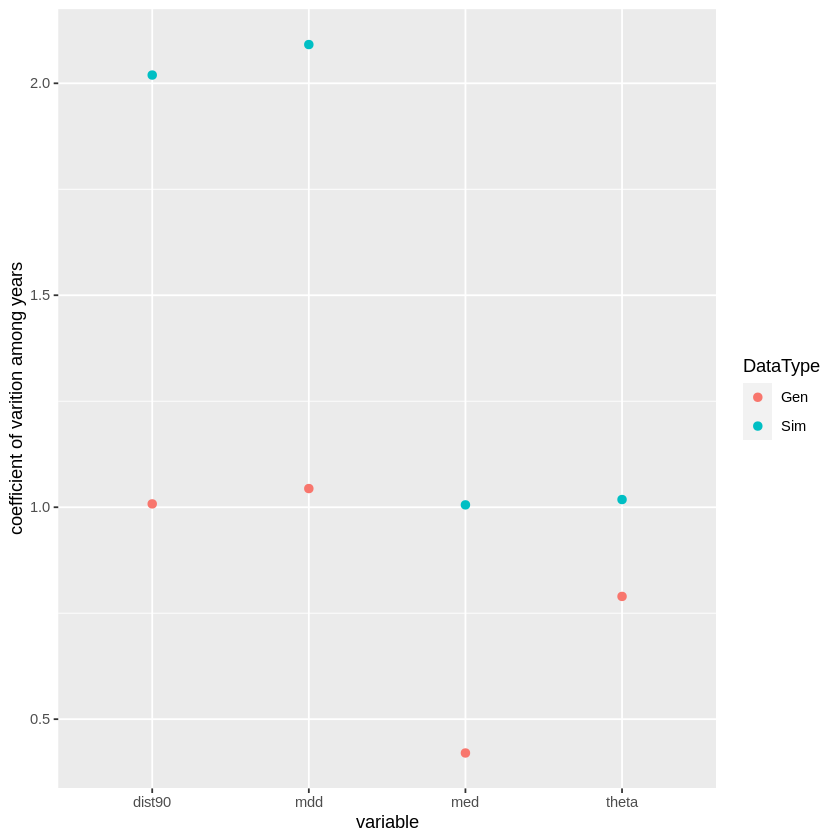

In [120]:
CVPlot <- ggplot(data=CompareCV, aes(x=variable, y=value, color=data_type)) +
    geom_point(size=2) +
    ylab("coefficient of varition among years") #+
   # ggtitle()
    #geom_point(aes(x=SimMDD, y=GenMDD), color="blue")
CVPlot
#ggsave(filename="SimulationGeneticFitsCVComparison.png", plot= CVPlot, path="~/oceanography/script_output/KernelFits/Plots/" )


In [ ]:
ggplot(data=SimKernelVar, aes(x=Adj, y=mdd, color=year, fill=year), alpha=0.5) +
    geom_point(data=SimPlusGenFits, aes(x=Year, y=AvgSimMDD, shape=Adj), fill=NA, color="black", size=3) + 
    geom_point(data=SimPlusGenFits, aes(x=Year, y=GenMDD), fill="red", color="red") + # with all fits


In [77]:
head(CombinedSims)
#head(SimPlusGenFits %>% spread(metric, value))

Year,k,theta,mdd,med,dist90,iteration,Adj
2012,2.263923,0.2645823,47.647397,11.23,114.86,1,SurvNoRecentRec
2012,-2.751382,2.5443994,8.185826,7.23,16.34,2,SurvNoRecentRec
2012,-2.396769,1.2721366,8.291947,6.25,18.34,3,SurvNoRecentRec
2012,-2.770307,2.6547136,8.260620,7.34,16.40,4,SurvNoRecentRec
2012,-2.433092,1.3359269,8.226354,6.30,18.05,5,SurvNoRecentRec
2012,-2.241767,1.1622086,7.788861,5.70,17.49,6,SurvNoRecentRec


Warning message:
“Removed 80 rows containing non-finite values (stat_ydensity).”Saving 6.67 x 6.67 in image
Warning message:
“Removed 80 rows containing non-finite values (stat_ydensity).”

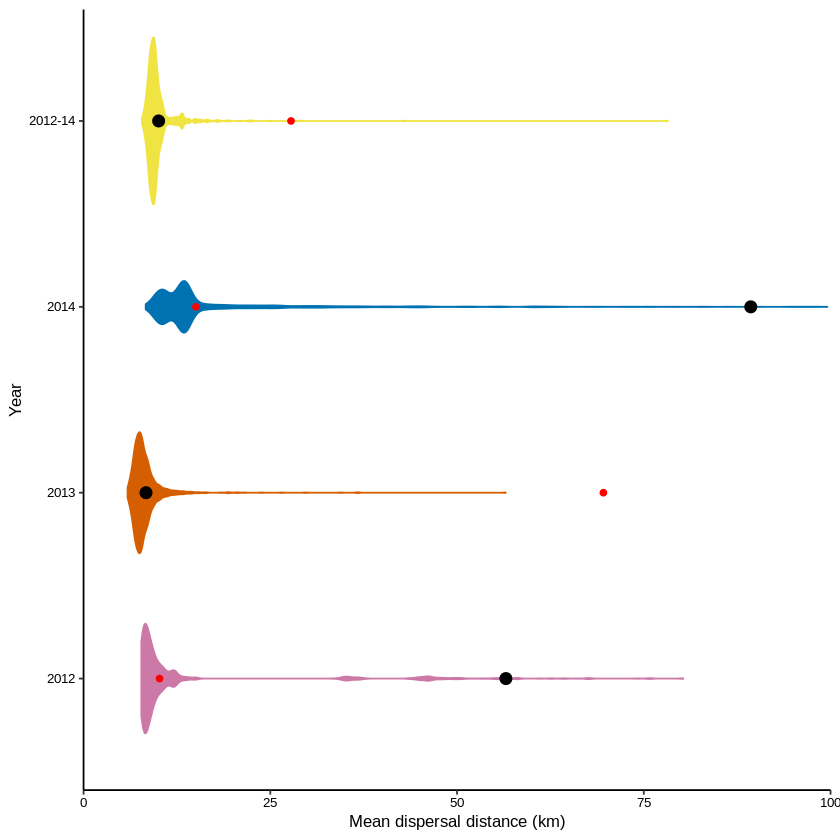

In [168]:
cbbPalette <- c("#000000", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7")
cbbPalette_rev <- rev(cbbPalette)

CombinedSims$Year <- factor(CombinedSims$Year, levels=c("2012", "2013", "2014", "2012-14"))
SimPlusGenFits$Year <- factor(SimPlusGenFits$Year, levels=c("2012", "2013", "2014", "2012-14"))
#PointsToPlot <- CompareFits %>% filter(Adj=="SurvNoRecentRec")
#PointsToPlot$Year <- factor(PointsToPlot$Year, levels=c("2012", "2013", "2014", "2012-14"))


mdd_violin <- ggplot(data=CombinedSims, aes(x=Year, y=mdd, color=Year, fill=Year), alpha=0.5) +
    geom_violin() +
    geom_point(data=PointsToPlot, aes(x=Year, y=SimMDD), fill=NA, color="black", size=3) + 
    geom_point(data=PointsToPlot, aes(x=Year, y=GenMDD), fill="red", color="red") + # with all fits
    #geom_point(data=kernels %>% filter(Year %in% c("2012", "2013", "2014", "all")), aes(x=Year, y=MeanDispDist), fill="black",color="darkgray", shape=24) + #genetic estimates
    coord_flip() +
    scale_shape_discrete(name = "Adjustment", labels = c("only >3.5 cm", "none", "only >3.5 cm and survival weighting"))+
    #scale_x_continuous(limits = c(0, 100), expand=c(0,0)) +
    scale_y_continuous(limits = c(0, 100), expand = c(0,0))+
    theme(panel.grid.major = element_blank(),
    plot.margin=unit(c(0.2,0.2,0.2,0.2),"cm"),
    panel.grid.minor = element_blank(), 
    panel.background = element_blank(), #,
    axis.line = element_line(colour = "black")) +
    xlab("Year") + 
    ylab("Mean dispersal distance (km)") +
    theme(axis.text.x = element_text(size=8, color="black", family="Helvetica"),#15 for publication, 20 for presentation #element_text(size=15, color="black", family="Helvetica"),
    axis.text.y =  element_text(size=8, color="black", family="Helvetica"),
    axis.title.y =  element_text(size=10, color="black", family="Helvetica"), 
    axis.title.x =  element_text(size=10, color="black", family="Helvetica")) + 
    scale_colour_manual(values=cbbPalette_rev)+
    scale_fill_manual(values=cbbPalette_rev) +
    theme(legend.position = "none") 
    #scale_y_continuous(breaks = 1:2000, labels = c(1:50,"break",1000:2000))
mdd_violin 
ggplot2::ggsave(filename="SimMeanDispDistPlusGenPointsSurvNoRecentRec.png",  plot=mdd_violin, path="~/oceanography/script_output/KernelFits/Plots/")


Warning message:
“Removed 344 rows containing non-finite values (stat_ydensity).”Saving 6.67 x 6.67 in image
Warning message:
“Removed 344 rows containing non-finite values (stat_ydensity).”

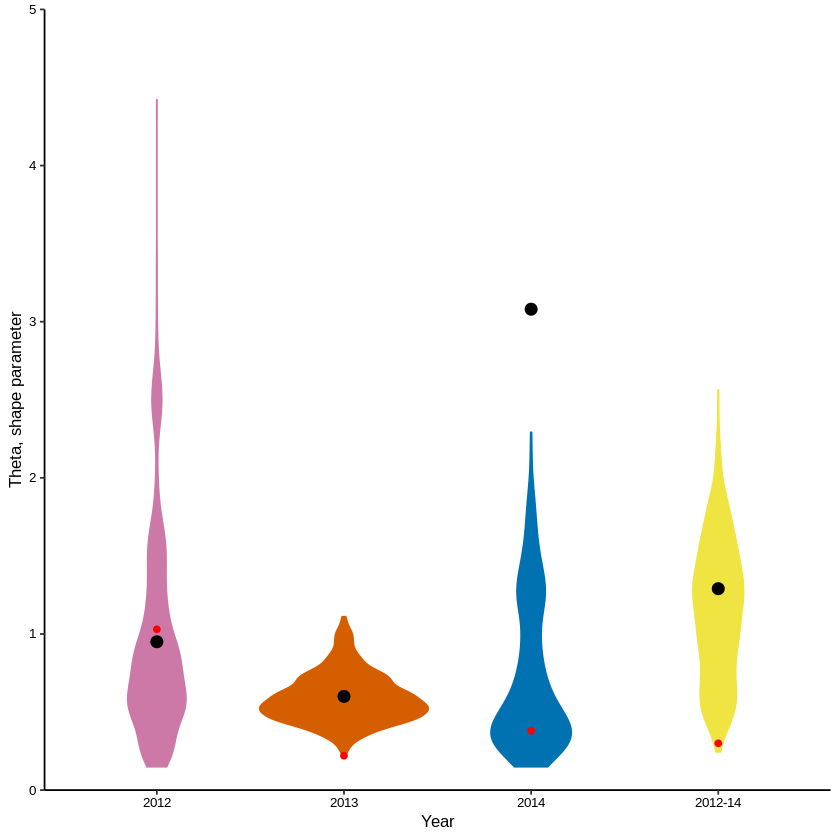

In [167]:
cbbPalette <- c("#000000", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7")
cbbPalette_rev <- rev(cbbPalette)

CombinedSims$year <- factor(CombinedSims$year, levels=c("2012", "2013", "2014", "2012-14"))
SimPlusGenFits$Year <- factor(SimPlusGenFits$Year, levels=c("2012", "2013", "2014", "2012-14"))
PointsToPlot <- CompareFits %>% filter(Adj=="SurvNoRecentRec")
PointsToPlot$Year <- factor(PointsToPlot$Year, levels=c("2012", "2013", "2014", "2012-14"))


theta_violin <- ggplot(data=CombinedSims %>% filter(Adj=="SurvNoRecentRec"), aes(x=year, y=theta, color=year, fill=year), alpha=0.5) +
    geom_violin() +
    geom_point(data=PointsToPlot, aes(x=Year, y=SimTheta), fill=NA, color="black", size=3) + 
    geom_point(data=PointsToPlot, aes(x=Year, y=GenTheta), fill="red", color="red") + # with all fits
    #geom_point(data=kernels %>% filter(Year %in% c("2012", "2013", "2014", "all")), aes(x=Year, y=MeanDispDist), fill="black",color="darkgray", shape=24) + #genetic estimates
   # coord_flip() +
    scale_shape_discrete(name = "Adjustment", labels = c("only >3.5 cm", "none", "only >3.5 cm and survival weighting"))+
    #scale_x_continuous(limits = c(0, 100), expand=c(0,0)) +
    scale_y_continuous(limits = c(0, 5), expand = c(0,0))+
    theme(panel.grid.major = element_blank(),
    plot.margin=unit(c(0.2,0.2,0.2,0.2),"cm"),
    panel.grid.minor = element_blank(), 
    panel.background = element_blank(), #,
    axis.line = element_line(colour = "black")) +
    xlab("Year") + 
    ylab("Theta, shape parameter") +
    theme(axis.text.x = element_text(size=8, color="black", family="Helvetica"),#15 for publication, 20 for presentation #element_text(size=15, color="black", family="Helvetica"),
    axis.text.y =  element_text(size=8, color="black", family="Helvetica"),
    axis.title.y =  element_text(size=10, color="black", family="Helvetica"), 
    axis.title.x =  element_text(size=10, color="black", family="Helvetica")) + 
    scale_colour_manual(values=cbbPalette_rev)+
    scale_fill_manual(values=cbbPalette_rev) +
    theme(legend.position = "none") 
    #scale_y_continuous(breaks = 1:2000, labels = c(1:50,"break",1000:2000))
theta_violin 
ggplot2::ggsave(filename="SimThetaPlusGenPointsSurvNoRecentRec.png",  plot=theta_violin, path="~/oceanography/script_output/KernelFits/Plots/")


In [154]:
str(PointsToPlot)

tibble [4 × 14] (S3: grouped_df/tbl_df/tbl/data.frame)
 $ Year            : Factor w/ 4 levels "2012","2013",..: 1 4 2 3
 $ GenDist90       : num [1:4] 23.3 68.7 157.4 38.1
 $ GenK            : num [1:4] -2.36 1.68 4.04 0.49
 $ GenMDD          : num [1:4] 10.2 27.8 69.6 15
 $ GenMed          : num [1:4] 7.13 7.71 12.2 5.53
 $ GenTheta        : num [1:4] 1.03 0.3 0.22 0.38
 $ Adj             : chr [1:4] "SurvNoRecentRec" "SurvNoRecentRec" "SurvNoRecentRec" "SurvNoRecentRec"
 $ SimDist90       : num [1:4] 107.2 22.9 20.7 173.1
 $ SimK            : num [1:4] -1.11 -2.14 -0.61 -1.61
 $ SimMDD          : num [1:4] 56.54 10.05 8.36 89.32
 $ SimMed          : num [1:4] 9.67 6.86 4.14 16.66
 $ SimTheta        : num [1:4] 0.95 1.29 0.6 3.08
 $ MDDDiffGenVSim  : num [1:4] 46.4 17.7 61.2 74.3
 $ ThetaDiffGenVSim: num [1:4] 0.08 0.99 0.38 2.7
 - attr(*, "groups")= tibble [4 × 2] (S3: tbl_df/tbl/data.frame)
  ..$ Year : Factor w/ 4 levels "2012","2013",..: 1 2 3 4
  ..$ .rows: list<int> [1:4] 
  ..

In [161]:
#read in the seasonal simulation kernel fits

#no adjustments
SimulatedKernelsNEM <-  read.csv(file="~/oceanography/script_output/KernelFits/100SimulatedKernelsNEM.csv", header=T) %>%
    mutate(Adj="no")
SimulatedKernelsSWM <-  read.csv(file="~/oceanography/script_output/KernelFits/100SimulatedKernelsSWM.csv", header=T) %>%
    mutate(Adj="no")

#adjusting for survival and growth
SimulatedKernelsNEMSurvGrowth <-  read.csv(file="~/oceanography/script_output/KernelFits/100SimulatedKernelsNEMSurvGrowth.csv", header=T) %>%
    mutate(Adj="SurvGrowth")
SimulatedKernelsSWMSurvGrowth <-  read.csv(file="~/oceanography/script_output/KernelFits/100SimulatedKernelsSWMSurvGrowth.csv", header=T) %>%
    mutate(Adj="SurvGrowth")

#adjusting for growth
SimulatedKernelsNEMGrowth <-  read.csv(file="~/oceanography/script_output/KernelFits/100SimulatedKernelsNEMGrowth.csv", header=T) %>%
    mutate(Adj="Growth")
SimulatedKernelsSWMGrowth <-  read.csv(file="~/oceanography/script_output/KernelFits/100SimulatedKernelsSWMGrowth.csv", header=T) %>%
    mutate(Adj="Growth")

CombinedSeasons <- bind_rows(SimulatedKernelsNEM, SimulatedKernelsSWM, SimulatedKernelsNEMSurvGrowth, SimulatedKernelsSWMSurvGrowth, SimulatedKernelsNEMGrowth, SimulatedKernelsSWMGrowth) %>%
    rename(Season="season") 

#empirical seasons for 2012-2014
SeasonalKernels2012_14 <- read.csv(file="~/oceanography/empirical_data/genetics/SeasonalGenKernelsForROMSComp.csv", header=T) %>%
    rename(Season="season",GenK="k", GenTheta="theta", GenMDD="mdd", GenMed="med", GenDist90="dist90") %>%
    mutate(GenK=round(GenK, digits=2)) %>%
    mutate(GenTheta=round(GenTheta, digits=2)) %>%
    mutate(GenMDD=round(GenMDD, digits=2)) %>%
    mutate(TimeFrame="2012-14")#%>%
    #mutate(JoinKey="all")


SeasonalKernels2012_18 <- read.csv(file="~/parentage/kernel_fitting/1340_loci/final_results/tables/RecruitSizeAsSeasonlity_summary.csv", header=T) %>%
    select(Season, best_k, best_theta, MeanDispersalDistance, MedianDispersalDistance, Dist90Retained) %>%    
    rename(GenK="best_k", GenTheta="best_theta", GenMDD="MeanDispersalDistance", GenMed="MedianDispersalDistance", GenDist90="Dist90Retained") %>%
    mutate(GenMDD=round(GenMDD, digits=2)) %>%
    mutate(TimeFrame="2012-18")#%>%
    #mutate(JoinKey="all")

GenSeasonalKernels <- bind_rows(SeasonalKernels2012_14, SeasonalKernels2012_18)

In [151]:
head(CombinedSeasons)

Season,k,theta,mdd,med,dist90,iteration,Adj
NEM,-2.49,1.30,8.94,6.78,19.71,1,no
NEM,0.85,0.34,21.84,7.14,55.00,2,no
NEM,-1.38,0.64,10.05,5.59,24.73,3,no
NEM,-2.06,0.91,9.06,6.05,21.17,4,no
NEM,-2.52,1.33,9.04,6.91,19.86,5,no
NEM,-1.92,0.84,9.04,5.82,21.40,6,no


In [162]:
AvgSeasonalKernels <- CombinedSeasons %>% 
    select(-iteration) %>%
    group_by(Season, Adj) %>%
    summarise_each(funs(mean)) %>%
    mutate(k=round(k, digits=2)) %>%
    mutate(theta=round(theta, digits=2)) %>%
    mutate(mdd=round(mdd, digits=2))%>%
    mutate(med=round(med, digits=2))%>%
    mutate(dist90=round(dist90, digits=2)) %>%
    rename(AvgSimK="k", AvgSimTheta="theta", AvgSimMDD="mdd", AvgSimMed="med", AvgSimDist90="dist90") %>%
    mutate(TimeFrame="2012-14")# %>%
    #mutate(JoinKey="all")

In [189]:
SimPlusGenFitsSeasons <- right_join(AvgSeasonalKernels, GenSeasonalKernels, by=c("Season", "TimeFrame"))%>%
    mutate(MDDDiffGenVSim=abs(GenMDD-AvgSimMDD)) %>%
    arrange(MDDDiffGenVSim) %>%
    mutate(GenK=round(GenK, digits=2)) %>%
    mutate(GenTheta=round(GenTheta, digits=2)) %>%
    mutate(GenMDD=round(GenMDD, digits=2))

SimPlusGenFitsSeasons %>%
    group_by(Season) %>%
    filter(MDDDiffGenVSim==min(MDDDiffGenVSim, na.rm=T))

SimPlusGenFitsSeasons

#write.csv(SimPlusGenFits, file="~/oceanography/script_output/KernelFits/SimPlusGenKernelFitsSeasons.csv", row.names=F)

Season,Adj,AvgSimK,AvgSimTheta,AvgSimMDD,AvgSimMed,AvgSimDist90,TimeFrame,GenK,GenTheta,GenMDD,GenMed,GenDist90,MDDDiffGenVSim
SWM,no,-2.45,1.39,8.58,6.57,18.77,2012-14,-1.62,0.76,8.34,5.1,20.07,0.24
NEM,SurvGrowth,-2.02,1.17,10.10,6.69,23.37,2012-14,6.95,0.15,2755.86,212.8,4810.04,2745.76


Season,Adj,AvgSimK,AvgSimTheta,AvgSimMDD,AvgSimMed,AvgSimDist90,TimeFrame,GenK,GenTheta,GenMDD,GenMed,GenDist90,MDDDiffGenVSim
SWM,no,-2.45,1.39,8.58,6.57,18.77,2012-14,-1.62,0.76,8.34,5.10,20.07,0.24
SWM,SurvGrowth,-2.44,1.37,8.63,6.59,18.94,2012-14,-1.62,0.76,8.34,5.10,20.07,0.29
SWM,Growth,-2.40,1.32,8.66,6.52,19.13,2012-14,-1.62,0.76,8.34,5.10,20.07,0.32
NEM,SurvGrowth,-2.02,1.17,10.10,6.69,23.37,2012-14,6.95,0.15,2755.86,212.80,4810.04,2745.76
NEM,Growth,-2.04,1.17,10.01,6.66,23.13,2012-14,6.95,0.15,2755.86,212.80,4810.04,2745.85
NEM,no,-2.08,1.26,9.95,6.72,22.82,2012-14,6.95,0.15,2755.86,212.80,4810.04,2745.91
SWM,NA,NA,NA,NA,NA,NA,2012-18,-2.60,1.58,8.57,6.87,18.32,NA
NEM,NA,NA,NA,NA,NA,NA,2012-18,-0.89,0.56,9.45,4.82,23.60,NA


Warning message:
“Removed 2 rows containing missing values (geom_point).”Saving 6.67 x 6.67 in image
Warning message:
“Removed 2 rows containing missing values (geom_point).”

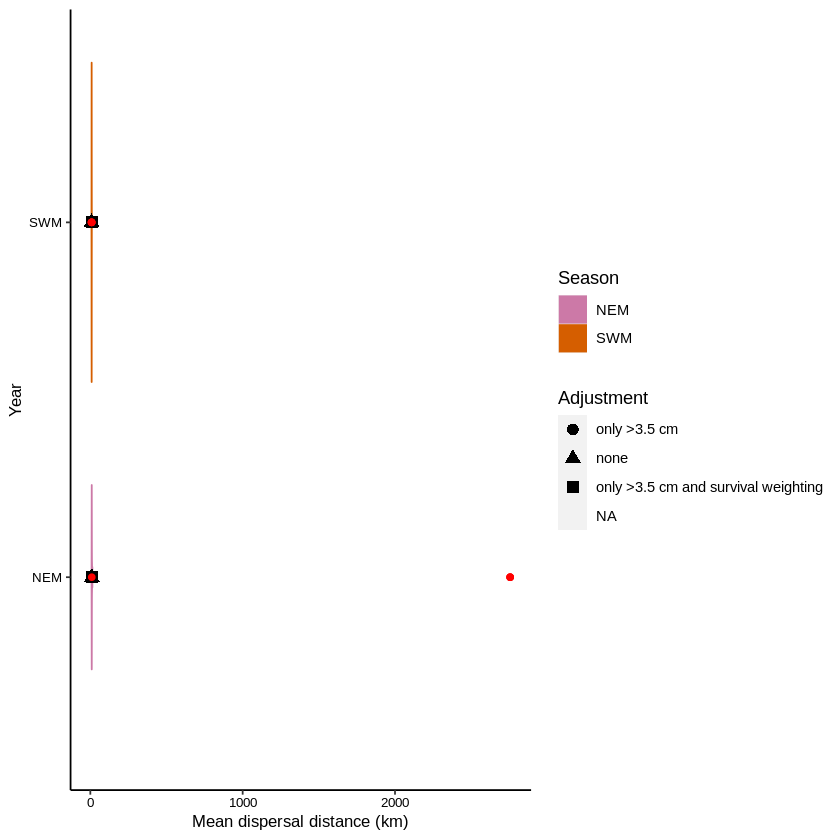

In [193]:
cbbPalette <- c("#000000", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7")
cbbPalette_rev <- rev(cbbPalette)

#CombinedSeasons$Season <- factor(CombinedSeasons$Season, levels=c("2012", "2013", "2014", "2012-14"))
#SimPlusGenFitsSeasons$Season <- factor(SimPlusGenFitsSeasons$Season, levels=c("2012", "2013", "2014", "2012-14"))

mdd_violin <- ggplot(data=CombinedSeasons, aes(x=Season, y=mdd, color=Season, fill=Season), alpha=0.5) +
    geom_violin() +
    geom_point(data=SimPlusGenFitsSeasons, aes(x=Season, y=AvgSimMDD, shape=Adj), fill=NA, color="black", size=3) + 
    geom_point(data=SimPlusGenFitsSeasons, aes(x=Season, y=GenMDD), fill="red", color="red") + # with all fits
    #geom_point(data=kernels %>% filter(Year %in% c("2012", "2013", "2014", "all")), aes(x=Year, y=MeanDispDist), fill="black",color="darkgray", shape=24) + #genetic estimates
    coord_flip() +
    scale_shape_discrete(name = "Adjustment", labels = c("only >3.5 cm", "none", "only >3.5 cm and survival weighting"))+
    #scale_x_continuous(limits = c(0, 100), expand=c(0,0)) +
    #scale_y_continuous(limits = c(0, 30), expand = c(0,0))+
    theme(panel.grid.major = element_blank(),
    plot.margin=unit(c(0.2,0.2,0.2,0.2),"cm"),
    panel.grid.minor = element_blank(), 
    panel.background = element_blank(), #,
    axis.line = element_line(colour = "black")) +
    xlab("Year") + 
    ylab("Mean dispersal distance (km)") +
    theme(axis.text.x = element_text(size=8, color="black", family="Helvetica"),#15 for publication, 20 for presentation #element_text(size=15, color="black", family="Helvetica"),
    axis.text.y =  element_text(size=8, color="black", family="Helvetica"),
    axis.title.y =  element_text(size=10, color="black", family="Helvetica"), 
    axis.title.x =  element_text(size=10, color="black", family="Helvetica")) + 
    scale_colour_manual(values=cbbPalette_rev)+
    scale_fill_manual(values=cbbPalette_rev)
    #scale_y_continuous(breaks = 1:2000, labels = c(1:50,"break",1000:2000))
mdd_violin
ggplot2::ggsave(filename="SimMeanDispDistPlusGenPointsSeasons.png",  plot=mdd_violin, path="~/oceanography/script_output/KernelFits/Plots/")


In [192]:
cbbPalette <- c("#000000", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7")
cbbPalette_rev <- rev(cbbPalette)

mdd_violin <- ggplot(data=SimCombinedSummary, aes(x=year, y=mdd, color=year, fill=year), alpha=0.5) +
    geom_violin() +
    #geom_point(data=AverageFits2, aes(x=year, y=mdd), fill="snow",color="darkgray", shape=21) + #without borderline fits
    geom_point(data=AverageFits, aes(x=year, y=mdd), fill="black ",color="darkgray", shape=21) + # with all fits
    geom_point(data=kernels %>% filter(Year %in% c("2012", "2013", "2014", "all")), aes(x=Year, y=MeanDispDist), fill="black",color="darkgray", shape=24) + #genetic estimates
    coord_flip() +
    #scale_x_continuous(limits = c(0, 100), expand=c(0,0)) +
    scale_y_continuous(limits = c(0, 83), expand = c(0,0))+
    theme(panel.grid.major = element_blank(),
    plot.margin=unit(c(0.2,0.2,0.2,0.2),"cm"),
    panel.grid.minor = element_blank(), 
    panel.background = element_blank(), #,
    axis.line = element_line(colour = "black")) +
    xlab("Year") + 
    ylab("Mean dispersal distance (km)") +
    theme(axis.text.x = element_text(size=8, color="black", family="Helvetica"),#15 for publication, 20 for presentation #element_text(size=15, color="black", family="Helvetica"),
    axis.text.y =  element_text(size=8, color="black", family="Helvetica"),
    axis.title.y =  element_text(size=10, color="black", family="Helvetica"), 
    axis.title.x =  element_text(size=10, color="black", family="Helvetica"),    
    legend.position = "none") + 
    scale_colour_manual(values=cbbPalette_rev)+
    scale_fill_manual(values=cbbPalette_rev)
    #scale_y_continuous(breaks = 1:2000, labels = c(1:50,"break",1000:2000))
mdd_violin
ggplot2::ggsave(filename="SimMeanDispDistPlusGenPoints.png",  plot=mdd_violin, path="~/oceanography/script_output/KernelFits/Plots/")


ERROR: Error in ggplot(data = SimCombinedSummary, aes(x = year, y = mdd, color = year, : object 'SimCombinedSummary' not found


In [115]:
(SimPlusGenFits)

year,SimK,SimTheta,SimMDD,SimKurtosis,GenK,GenTheta,GenMDD,GenMedDispDist
2012,-1.828326,1.250510,10.127328,15.518027,-2.36,1.03,10.165094,7.13
2013,-1.242150,0.804757,8.091848,13.967938,4.04,0.22,69.586280,12.20
2014,-1.926596,1.243059,26.376964,86.415760,0.49,0.38,15.037515,5.53
all,-1.919426,1.014670,10.219857,8.635482,-2.51,1.49,8.153016,6.44


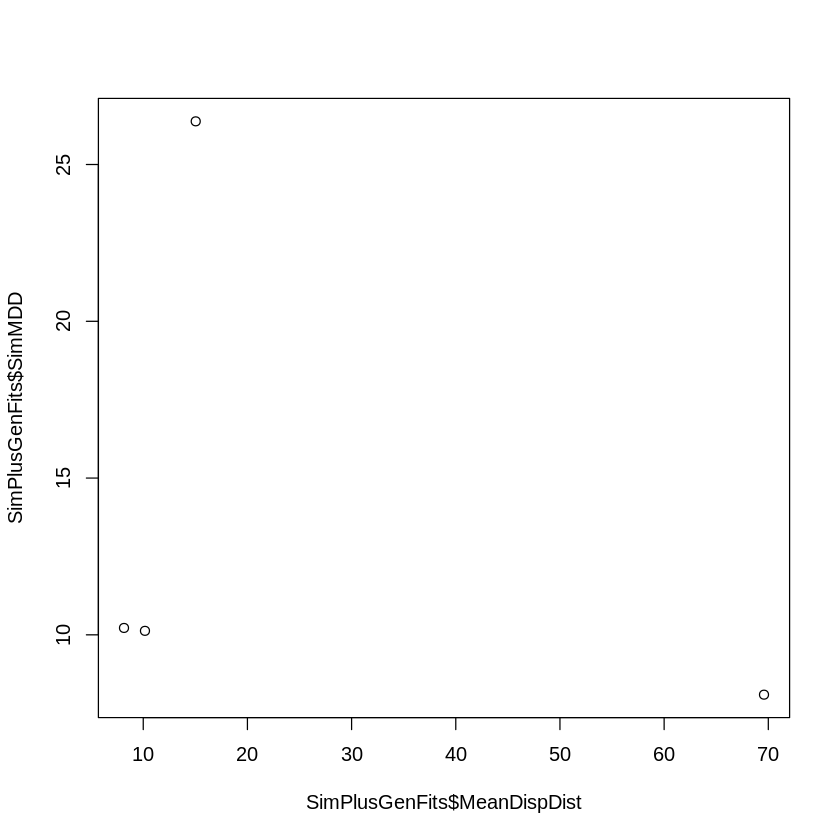

In [95]:
plot(SimPlusGenFits$SimMDD~SimPlusGenFits$MeanDispDist)

In [60]:
MDDAllYear <- CombinedSims %>% 
    filter(year=="all")
#pdf("~/oceanography/script_output/KernelFits/Plots/MeanDispDistHist2012-14.pdf")
hist(MDDAllYear$mdd, breaks=100, main=NULL, xlab="Mean dispersal distance (km)")
#dev.off()
summary(MDDAllYear$mdd)

Warning message in min(x):
“no non-missing arguments to min; returning Inf”Warning message in max(x):
“no non-missing arguments to max; returning -Inf”

ERROR: Error in hist.default(MDDAllYear$mdd, breaks = 100, main = NULL, xlab = "Mean dispersal distance (km)"): character(0)


In [97]:
#test for correlations
cor.test(SimPlusGenFits$SimMDD, SimPlusGenFits$MeanDispDist,  method = "pearson")
cor.test(SimPlusGenFits$SimTheta, SimPlusGenFits$GenTheta,  method = "pearson")



	Pearson's product-moment correlation

data:  SimPlusGenFits$SimMDD and SimPlusGenFits$MeanDispDist
t = -0.53384, df = 2, p-value = 0.6468
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.9812079  0.9202897
sample estimates:
       cor 
-0.3531582 



	Pearson's product-moment correlation

data:  SimPlusGenFits$SimTheta and SimPlusGenFits$GenTheta
t = 0.32913, df = 2, p-value = 0.7733
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.9389710  0.9752907
sample estimates:
      cor 
0.2266754 


In [17]:
#seasons
SimulatedKernelsNEM <-  read.csv(file="~/oceanography/script_output/KernelFits/100SimulatedKernelsNEM.csv", header=T)
SimulatedKernelsSWM <-  read.csv(file="~/oceanography/script_output/KernelFits/100SimulatedKernelsSWM.csv", header=T)
CombinedSeasons <- bind_rows(SimulatedKernelsNEM, SimulatedKernelsSWM) %>%
    select(-iteration)

In [24]:
SeasonalKernels <- read.csv(file="~/parentage/kernel_fitting/1340_loci/final_results/tables/RecruitSizeAsSeasonlity_summary.csv", header=T)
head(SeasonalKernels)

Season,RecruitSizeAtSampling,best_k,best_theta,k_CI95_lower,k_CI95_upper,theta_CI95_lower,theta_CI95_upper,MeanDispersalDistance,MeanDispDist_CI95_lower,MeanDispDist_CI95_upper,MedianDispersalDistance,MedianDispDist_CI95_lower,MedianDispDist_CI95_upper,Dist90Retained
SWM,> 4.5 cm,-2.60,1.58,-2.63,-2.47,1.34,1.59,8.574871,7.132250,10.39623,6.87,4.93,9.28,18.32
NEM,< 3.5 cm,-0.89,0.56,-1.46,-0.74,0.54,0.61,9.446898,6.014163,4272.46841,4.82,3.24,323.37,23.60
